In [1]:
from joblib import Parallel, delayed
import multiprocessing as mp
import numpy as np
import sys
import json_lines
import pandas as pd
import ijson
import matplotlib.pyplot as plt
import collections
from itertools import count
from numpy import linspace, loadtxt, ones, convolve
from random import randint
from matplotlib import style
style.use('fivethirtyeight')
%matplotlib inline

In [40]:
%%bash

head -n 1 2017-07-05.jsonl
# wc -l 2017-07-05.jsonl

{"_id": {"$oid": "58e09d8069fe9f52c4c3f1fa"}, "tag": "20170402", "btag": 121, "events": ["Financial Recovery"], "version": 3.0, "entities": [{"name": "Google Inc.", "type": "Public", "index": "S&P 500, Russell 1000, Russell 3000, Wilshire 5000, BARRON'S 400, NASDAQ 100", "region": "North America", "sector": "Technology", "ticker": "GOOG", "country": "United States", "exchange": "NASDAQ", "industry": "Computer Software: Programming, Data Processing", "entity_id": "EQ0000000044670269", "global_id": "BBG009S3NB30", "competitors": ["FB", "MSN", "YHOO"]}], "story_id": {"$oid": "58e09d8669fe9f52bf71f40d"}, "blog_rank": "", "companies": ["GOOG"], "article_id": {"$oid": "58e09d8069fe9f52c4c3f1fa"}, "ca_webrank": "", "crawled_at": "2017-04-02 06:42:39 UTC", "lexalytics": null, "source_url": "https://twitter.com/mashableng", "article_url": "https://twitter.com/mashableng/status/848424787353509888", "author_name": "MashableNG", "ca_newsrank": "", "ca_printcir": "", "provider_id": 6, "article_type

First, we will obtain the root key values of the data we are working with.

In [3]:
root_keys = []
with open('2017-07-05.jsonl', 'rb') as f:
    for item in json_lines.reader(f):
        for key in item.keys():
            root_keys.append(key)
        break
print(root_keys)

['_id', 'tag', 'btag', 'events', 'version', 'entities', 'story_id', 'blog_rank', 'companies', 'article_id', 'ca_webrank', 'crawled_at', 'lexalytics', 'source_url', 'article_url', 'author_name', 'ca_newsrank', 'ca_printcir', 'provider_id', 'article_type', 'author_email', 'event_groups', 'harvested_at', 'published_at', 'story_volume', 'accern_alerts', 'alexa_traffic', 'article_image', 'article_title', 'ca_rechpermil', 'event_summary', 'first_mention', 'article_source', 'article_content', 'article_summary', 'source_category', 'story_sentiment', 'accern_sentiment', 'story_saturation', 'article_sentiment', 'event_author_rank', 'event_source_rank', 'event_impact_score', 'overall_author_rank', 'overall_source_rank', 'story_alexa_traffic']


We will read the relevant data into a pandas dataframe. Due to the large size of the dataset (~20 GB), we will leave out data (keys) which won't be used immediately for anomaly detection purposes.

#### _Prototyping using weekly data_

We will be using *published_at* as our time variable. We ignore *harvested_at* since we are more concerned about when the article was published rather than when accern's API picked it up.

In [32]:
%%bash

# # A check to see if there are any rogue published_at values (i.e. they don't end with UTC)
# # Outputs any line which isn't ending with 'UTC'
# cat 2017-07-05.jsonl | jq -r '.published_at' | grep -v 'UTC$'

The *published_at* values are in order.

In [53]:
%%time

data_list = []
with open('2017-07-05.jsonl', 'rb') as f:
    for item in json_lines.reader(f):
        if '2017-04-09' in item['published_at']:
            break
        
        data_list.append({
            'published_at': item['published_at'],
            'accern_sentiment': item['accern_sentiment']
        })

CPU times: user 10.5 s, sys: 268 ms, total: 10.7 s
Wall time: 11.5 s


In [104]:
# Converting our data dict to a pandas dataframe
# df = pd.DataFrame(data_list)
# df = df.sort_values('published_at')
df['published_at'] = pd.to_datetime(df['published_at'])

In [60]:
# Function to compute moving average when provided with a pandas series and a window size.
def moving_average(data ,window_size):
    """ Computes moving average using discrete linear convolution of two one dimensional sequences.
    Args:
    -----
            data (pandas.Series): independent variable
            window_size (int): rolling window size

    Returns:
    --------
            ndarray of linear convolution

    References:
    ------------
    [1] Wikipedia, "Convolution", http://en.wikipedia.org/wiki/Convolution.
    [2] API Reference: https://docs.scipy.org/doc/numpy/reference/generated/numpy.convolve.html

    """
    window = np.ones(int(window_size))/float(window_size)
    return np.convolve(data, window, 'same')

In [95]:
# Function to classify anomalies based on rolling standard deviation
def explain_anomalies_rolling_std(y, window_size, sigma=1.0):
    """ Helps in exploring the anamolies using rolling standard deviation
    Args:
    -----
        y (pandas.Series): independent variable
        window_size (int): rolling window size
        sigma (int): value for standard deviation

    Returns:
    --------
        a dict (dict of 'standard_deviation': int, 'anomalies_dict': (index: value))
        containing information about the points indentified as anomalies
    """
    avg = moving_average(y, window_size)
    avg_list = avg.tolist()
    residual = y - avg
    # Calculate the variation in the distribution of the residual
#     testing_std = pd.rolling_std(residual, window_size)
    testing_std = residual.rolling(window=window_size, center=False).std()
    testing_std_as_df = pd.DataFrame(testing_std)
    rolling_std = testing_std_as_df.replace(np.nan,
                           testing_std_as_df.iloc[window_size - 1]).round(3).iloc[:,0].tolist()
    std = np.std(residual)
    return {'stationary standard deviation': round(std, 3),
           'anomalies_dict': collections.OrderedDict([(index, y_i)
                                                     for index, y_i, avg_i, rs_i in zip(count(),
                                                                                       y, avg_list, rolling_std)
                                 if (y_i > avg_i + (sigma * rs_i)) | (y_i < avg_i - (sigma *rs_i))])}

In [111]:
# This function is repsonsible for displaying how the function performs on the given dataset.
def plot_results(x, y, window_size, sigma_value=1,
                 text_xlabel="X Axis", text_ylabel="Y Axis", applying_rolling_std=False):
    """ Helps in generating the plot and flagging the anamolies.
        Supports both moving and stationary standard deviation. Use the 'applying_rolling_std' to switch
        between the two.
    Args:
    -----
        x (pandas.Series): dependent variable
        y (pandas.Series): independent variable
        window_size (int): rolling window size
        sigma_value (int): value for standard deviation
        text_xlabel (str): label for annotating the X Axis
        text_ylabel (str): label for annotatin the Y Axis
        applying_rolling_std (boolean): True/False for using rolling vs stationary standard deviation
    """
    plt.figure(figsize = (15,8))
    plt.plot(x, y, "k.")
    y_av = moving_average(y, window_size)
    plt.plot(x, y_av, color = 'green')
    plt.xlim(0, len(x))
    plt.xlabel(text_xlabel)
    plt.ylabel(text_ylabel)

    events = {}
    events = explain_anomalies_rolling_std(y, window_size=window_size, sigma=sigma_value)
    
    x_anomaly = np.fromiter(events['anomalies_dict'].keys(), dtype=int, count=len(events['anomalies_dict']))
    y_anomaly = np.fromiter(events['anomalies_dict'].values(), dtype=float,
                                            count=len(events['anomalies_dict']))
    plt.plot(x_anomaly, y_anomaly, "r*", markersize=12)

    # add grid and lines and enable the plot
    plt.grid(True)
    plt.show()

In [102]:
accern_score_anomalies = explain_anomalies_rolling_std(sigma=3.0, window_size=1000, y=df['accern_sentiment'])

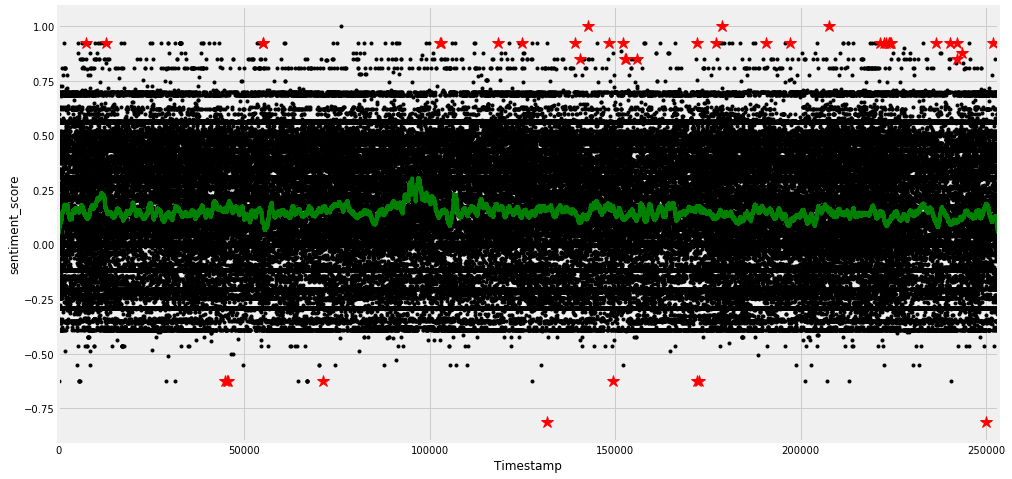

Information about the anomalies model:{'stationary standard deviation': 0.26700000000000002, 'anomalies_dict': OrderedDict([(7468, 0.92500000000000004), (12844, 0.92500000000000004), (44801, -0.623), (45468, -0.623), (45607, -0.623), (55062, 0.92500000000000004), (55073, 0.92500000000000004), (71225, -0.623), (102908, 0.92500000000000004), (102974, 0.92500000000000004), (118384, 0.92500000000000004), (124783, 0.92500000000000004), (131735, -0.81000000000000005), (139242, 0.92500000000000004), (140517, 0.85199999999999998), (142555, 1.0), (148328, 0.92500000000000004), (149434, -0.623), (152181, 0.92500000000000004), (152744, 0.85199999999999998), (153013, 0.85199999999999998), (155758, 0.85199999999999998), (171919, 0.92500000000000004), (171946, -0.623), (172502, -0.623), (177131, 0.92500000000000004), (178721, 1.0), (190656, 0.92500000000000004), (197061, 0.92500000000000004), (207678, 1.0), (221333, 0.92500000000000004), (222307, 0.92500000000000004), (223030, 0.92500000000000004), 

In [112]:
x = df.index
Y = df['accern_sentiment']

# plot the results
plot_results(x, y=Y, window_size=1000, text_xlabel="Timestamp", sigma_value=3,
            text_ylabel="sentiment_score")
events = explain_anomalies_rolling_std(Y, window_size=1000, sigma=3)

# Display the anomaly dict
print("Information about the anomalies model:{}".format(events))

In [ ]:
%%time

# keys_to_remove = ['_id', 'btag', 'version', 'article_id', 'lexalytics', 'source_url', 'article_url', 'ca_newsrank', 'provider_id', 'author_email', 'harvested_at', 'published_at', 'accern_alerts', 'article_image', 'article_title', 'ca_rechpermil', 'event_summary', 'article_source', 'article_content', 'article_summary']
# item_list = []
# temp = 0
accern_sentiments = []
with open('2017-07-05.jsonl', 'rb') as f:
    for item in json_lines.reader(f):
#         temp += 1
#         for key in keys_to_remove:
#             item.pop(key)
        accern_sentiments.append(item['accern_sentiment'])
#         if temp > 50000:
#             break
# print(count)

In [ ]:
# %%time

# # keys_to_remove = ['_id', 'btag', 'version', 'article_id', 'lexalytics', 'source_url', 'article_url', 'ca_newsrank', 'provider_id', 'author_email', 'harvested_at', 'published_at', 'accern_alerts', 'article_image', 'article_title', 'ca_rechpermil', 'event_summary', 'article_source', 'article_content', 'article_summary']
# # item_list = []

# break_count = [10]

# def hollow_func(break_count):
#     count = 0
#     with open('2017-07-05.jsonl', 'rb') as f:
#         for item in json_lines.reader(f):
#             count += 1
#             if count > break_count:
#                 break
#     return count

# counts = Parallel(n_jobs=6)(delayed(hollow_func) for i in break_count)

# print(counts)

# Extract columns
# id_list = []
# tags = []
# events = []
# story_ids = []
# blog_ranks = []
# companies = []
# ca_webranks = []
# crawled_at = []
# ca_newsranks = []
# article_types = []
# event_groups = []
# story_volumes = []
# alexa_traffic = []
# first_mentions = []
# source_categories = []
# story_sentiments = []
# accern_sentiments = []
# story_saturations = []
# article_sentiments = []
# event_author_ranks = []
# event_source_ranks = []
# event_impact_scores = []
# overall_author_ranks = []
# overall_source_ranks = []
# story_alexa_traffics = []

# count = 0
# with open('2017-07-05.jsonl', 'rb') as f:
#     for item in json_lines.reader(f):
#         id_list.append(item['_id'])
#         tags.append(item['tag'])
#         events.append(item['events'])
#         story_ids.append(item['story_id'])
#         blog_ranks.append(item['blog_rank'])
#         companies.append(item['companies'])
#         ca_webranks.append(item['ca_webrank'])
#         crawled_at.append(item['crawled_at'])
#         ca_newsranks.append(item['ca_newsrank'])
#         article_types.append(item['article_type'])
#         event_groups.append(item['event_groups'])
#         story_volumes.append(item['story_volume'])
#         alexa_traffic.append(item['alexa_traffic'])
#         first_mentions.append(item['first_mention'])
#         source_categories.append(item['source_category'])
#         story_sentiments.append(item['story_sentiment'])
#         accern_sentiments.append(item['accern_sentiment'])
#         story_saturations.append(item['story_saturation'])
#         article_sentiments.append(item['article_sentiment'])
#         event_author_ranks.append(item['event_author_rank'])
#         event_source_ranks.append(item['event_source_rank'])
#         event_impact_scores.append(item['event_impact_score'])
#         overall_author_ranks.append(item['overall_author_rank'])
#         overall_source_ranks.append(item['overall_source_rank'])
#         story_alexa_traffics.append(item['story_alexa_traffic'])
        
# #         count += 1
# #         if count > 5:
# #             break

# plt.plot(accern_sentiments[1:100])
# plt.show()

# (sys.getsizeof(id_list) + sys.getsizeof(tags) + sys.getsizeof(events) + sys.getsizeof(story_ids) +
# sys.getsizeof(blog_ranks) +
# sys.getsizeof(companies) + 
# sys.getsizeof(ca_webranks) +
# sys.getsizeof(crawled_at) +
# sys.getsizeof(ca_newsranks) +
# sys.getsizeof(article_types) +
# sys.getsizeof(event_groups) +
# sys.getsizeof(story_volumes) +
# sys.getsizeof(alexa_traffic) +
# sys.getsizeof(first_mentions) +
# sys.getsizeof(source_categories) +
# sys.getsizeof(story_sentiments) +
# sys.getsizeof(accern_sentiments) +
# sys.getsizeof(story_saturations) +
# sys.getsizeof(article_sentiments) +
# sys.getsizeof(event_author_ranks) +
# sys.getsizeof(event_source_ranks) +
# sys.getsizeof(event_impact_scores) +
# sys.getsizeof(overall_author_ranks) +
# sys.getsizeof(overall_source_ranks) +
# sys.getsizeof(story_alexa_traffics))